# Chapter 8 - Recommendation System

Paul E. Anderson

In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
home = str(Path.home()) # all other paths are relative to this path. change to something else if this is not the case on your system

Not every method falls directly under machine learning. Consider how you would recommend movies to a friend? You might ask them what kind of movies they like and then try to think of similar movies. And there we have it... you've performed _collaborative filtering_. You could go a step further and try to think of three other friends who have similar tastes to your friend. In collaborative filtering terminology you have defined the _neighborhood_.

User - any individual who provides ratings to a system

Ratings:
* Scalar ratings can consist of either numerical ratings, such as the 1-5 stars provided in MovieLens or ordinal ratings such as strongly agree, agree, neutral, disagree, strongly disagree.
* Binary ratings model choices between agree/disagree or good/bad.
* Unary ratings can indicate that a user has observed or purchased an item, or otherwise rated the item positively. The absence of a rating indicates that we have no information relating the user to the item (perhaps they purchased the item somewhere else).

Explicit ratings - users asked to provide an opinion on an item

Implicit ratings - ratings are inferred from actions

Examples: Users may visit a product page because they are interested in that product

What might someone do with CF:
* Help me find new items I might like.
* Advise me on a particular item. I have a particular item in mind; does the community know whether it is good or bad?
* Help me find a user (or some users) I might like.
* Help our group find something new that we might like.
* Help me find an item, new or not.

## Real dataset: Movielens

https://grouplens.org/datasets/movielens/

> MovieLens is a collaborative filtering system for movies. A
user of MovieLens rates movies using 1 to 5 stars, where 1 is "Awful" and 5 is "Must
See". MovieLens then uses the ratings of the community to recommend other movies
that user might be interested in, predict what that user might rate a movie,
or perform other tasks. - "Collaborative Filtering Recommender Systems"

In [4]:
import pandas as pd
import numpy as np

ratings = pd.read_csv(f'{home}/csc-466-student/data/movielens-small/ratings.csv') # you might need to change this path
ratings = ratings.dropna()
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies = pd.read_csv(f'{home}/csc-466-student/data/movielens-small/movies.csv')
movies = movies.dropna()
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Joining the data together
We need to join those two source dataframes into a single one called data. I do this by setting the index to movieId and then specifying an ``inner`` join which means that the movie has to exist on both sides of the join. Then I reset the index so that I can later set the multi-index of userId and movieId. The results of this are displayed below. Pandas is awesome, but it takes some getting used to how everything works.

In [9]:
data = movies.set_index('movieId').join(ratings.set_index('movieId'),how='inner').reset_index()
data = data.drop('timestamp',axis=1) # We won't need timestamp here
data.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


You can then calculate the average rating for a user:

In [10]:
data.set_index('userId').loc[1,'rating'].mean()

4.366379310344827

It would also be interesting to see the distribution of ratings across all users:

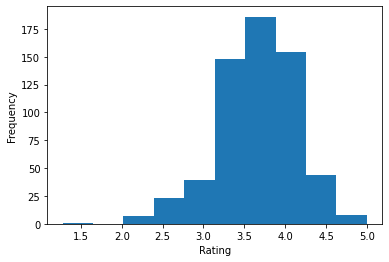

In [12]:
ax = data.reset_index().groupby('userId')['rating'].mean().plot.hist()
ax.set_xlabel('Rating');

**Stop and think:** How can we handle the genres column?

In [14]:
# Your solution here
genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


**Stop and think:** How would you calculate the average score per genre?

In [15]:
# Your solution here
means.sort_values()

genre
Horror                3.258195
Comedy                3.384721
Children              3.412956
Action                3.447984
Sci-Fi                3.455721
(no genres listed)    3.489362
Fantasy               3.491001
Thriller              3.493706
Romance               3.506511
Adventure             3.508609
Musical               3.563678
Western               3.583938
IMAX                  3.618335
Animation             3.629937
Mystery               3.632460
Drama                 3.656184
Crime                 3.658294
Documentary           3.797785
War                   3.808294
Film-Noir             3.920115
Name: rating, dtype: float64

How many unique users are in this small dataset?

In [16]:
len(ratings.userId.unique())

610

### Aside: Turning data into a matrix instead of a series
The functions ``stack()`` and ``unstack()`` are called multiple times in this lab. These functions allow me to easily change from a dataframe to a series and back again. Below I'm changing from the Series object to a DataFrame. The important thing to note is that each row is now a user! NaN values are inserted where a user did not rate movie.

In [30]:
ratings = data.set_index(['userId','movieId'])['rating']
ratings # as Series

userId  movieId
1       1          4.0
5       1          4.0
7       1          4.5
15      1          2.5
17      1          4.5
                  ... 
184     193581     4.0
        193583     3.5
        193585     3.5
        193587     3.5
331     193609     4.0
Name: rating, Length: 100836, dtype: float64

In [31]:
ratings.unstack()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
ratings.unstack().stack() # we can do this all day

userId  movieId
1       1          4.0
        3          4.0
        6          4.0
        47         5.0
        50         5.0
                  ... 
610     166534     4.0
        168248     5.0
        168250     5.0
        168252     5.0
        170875     3.0
Length: 100836, dtype: float64

Remember our initial analogy. We really want a way to return the users who have similar taste in movies to our friend. This means that we need a way to measure distance between users. The first thing we need to consider is what happens when a user doesn't rate a movie? 

**Stop and think:** Why is it a bad idea to fill in 0 for missing values without any other modifications to the data? What could help?

Your answer here

We've seen above that each user has a different baseline rating (average). It is a good idea to mean center each user:

In [33]:
ratings = ratings.unstack()
ratings = (ratings.T-ratings.mean(axis=1)).T
ratings = ratings.stack()
ratings

userId  movieId
1       1         -0.366379
        3         -0.366379
        6         -0.366379
        47         0.633621
        50         0.633621
                     ...   
610     166534     0.311444
        168248     1.311444
        168250     1.311444
        168252     1.311444
        170875    -0.688556
Length: 100836, dtype: float64

In [34]:
# Let's now convert this to a dataframe and fill in the zeros
ratings_df = ratings.unstack().fillna(0)
ratings_df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.000000,-0.366379,0.0,0.0,-0.366379,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-1.157399,0.000000,0.000000,0.0,0.0,0.000000,-1.157399,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.213904,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,-0.634176,-1.134176,-1.134176,0.0,0.0,0.000000,0.000000,0.0,0.0,0.865824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's say your friend is the first user:

In [35]:
x = ratings_df.loc[1]
x

movieId
1        -0.366379
2         0.000000
3        -0.366379
4         0.000000
5         0.000000
            ...   
193581    0.000000
193583    0.000000
193585    0.000000
193587    0.000000
193609    0.000000
Name: 1, Length: 9724, dtype: float64

### Finding neighborhood.
If we are hoping to predict movies for this user, then user-user collaborative filtering says find the ``N`` users that are similar. We should definitely drop out user 1 because it makes no sense to recommend to yourself. We then compute the cosine similarity between this user ``x`` and all other users in the db. We then reverse sort them, and then display the results.

**Stop and think:** Why would we not use Euclidean distance? Consider two users who fail to rate any movies?

##### Your solution here

${\displaystyle {\text{similarity}}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B} \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}$

In [36]:
db = ratings_df.drop(1) # Make database of all users except user 1
x = ratings_df.loc[1]
sims = db.apply(lambda y: (y.values*x.values).sum()/(np.sqrt((y**2).sum())*np.sqrt((x**2).sum())),axis=1)
sorted_sims = sims.sort_values()[::-1]
sorted_sims

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


userId
53          NaN
301    0.124799
597    0.102631
414    0.101348
477    0.099217
         ...   
395   -0.075800
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
Length: 609, dtype: float64

In [41]:
sum(ratings_df.loc[53]!=0) # Just fyi

0

### Grabing similar users
Let's set the network size to 10, and then grab those users :)

In [42]:
N=10
userIds = sorted_sims.dropna().iloc[:N].index
ratings_df.loc[userIds]

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
301,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.679825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.022573,0.000000,0.000000,0.0,0.000000,-0.977427,-2.977427,0.000000,0.0,-0.977427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,0.608043,-0.391957,0.608043,0.0,-1.391957,-0.391957,-0.391957,-0.391957,0.0,-0.391957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,0.263333,0.263333,-0.736667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,1.607143,0.000000,0.000000,0.0,0.000000,-0.392857,0.000000,0.000000,0.0,-0.392857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
369,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,0.960000,0.000000,0.000000,0.0,0.000000,0.000000,-0.040000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
535,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590,0.644231,-0.855769,-0.355769,0.0,-1.355769,0.144231,0.000000,0.000000,0.0,0.144231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Stop and think:** How do we make a prediction?

Your solution here

In [46]:
movies_not_seen = x.loc[x != 0].index
movies_not_seen

Int64Index([   1,    3,    6,   47,   50,   70,  101,  110,  151,  157,
            ...
            3671, 3702, 3703, 3729, 3740, 3744, 3793, 3809, 4006, 5060],
           dtype='int64', name='movieId', length=232)

In [48]:
average_ratings = db.loc[userIds].mean().loc[movies_not_seen].sort_values(ascending=False)
average_ratings

movieId
2858    0.765848
50      0.742203
356     0.718536
457     0.682515
1196    0.675385
          ...   
1552   -0.625779
736    -0.673743
673    -0.737725
733    -0.771485
2617   -1.250388
Length: 232, dtype: float64

In [54]:
data[['movieId','title']].drop_duplicates().set_index('movieId').loc[average_ratings.index]

,title
movieId,
2858,American Beauty (1999)
50,"Usual Suspects, The (1995)"
356,Forrest Gump (1994)
457,"Fugitive, The (1993)"
1196,Star Wars: Episode V - The Empire Strikes Back...
...,...
1552,Con Air (1997)
736,Twister (1996)
673,Space Jam (1996)


### What if we want to weight by the distance?

In other words, if a user is closer to our query user, then they should count more.

In [56]:
average_ratings_weighted = (db.loc[userIds].multiply(sorted_sims.iloc[:N],axis=0).sum()/sorted_sims.iloc[:N].sum()).sort_values(ascending=False)
average_ratings_weighted

movieId
2858    0.852397
457     0.764475
356     0.760230
50      0.747680
260     0.733189
          ...   
736    -0.790624
673    -0.802204
733    -0.924220
355    -1.017260
2617   -1.094406
Length: 9724, dtype: float64

In [57]:
data[['movieId','title']].drop_duplicates().set_index('movieId').loc[average_ratings_weighted.index]

,title
movieId,
2858,American Beauty (1999)
457,"Fugitive, The (1993)"
356,Forrest Gump (1994)
50,"Usual Suspects, The (1995)"
260,Star Wars: Episode IV - A New Hope (1977)
...,...
736,Twister (1996)
673,Space Jam (1996)
733,"Rock, The (1996)"


## User-user small dataset example

In [29]:
data2 = data.copy()
data = data['rating']

In [58]:
# grab some movies that were watched a lot
r=(ratings_df > 0).sum()
our_movies = r.sort_values(ascending=False).iloc[:10].index
our_movies

Int64Index([318, 356, 296, 593, 2571, 260, 2959, 527, 110, 50], dtype='int64', name='movieId')

In [59]:
our_data = ratings_df[our_movies] # grab only those movies

In [60]:
# Now grab just the users
our_users = (our_data>0).sum(axis=1).sort_values(ascending=False).iloc[:10].index

In [130]:
train_data = our_data.loc[our_users]
train_data

movieId,318,356,296,593,2571,260,2959,527,110,50
userId,,,,,,,,,,
307,1.834359,1.334359,1.834359,1.834359,0.834359,0.834359,1.334359,1.834359,0.834359,1.834359
590,1.144231,1.644231,1.144231,0.144231,0.644231,1.644231,0.144231,1.644231,0.644231,1.144231
18,1.267928,0.767928,0.267928,0.767928,0.767928,0.267928,0.767928,0.767928,0.767928,1.267928
17,0.790476,0.790476,0.790476,0.290476,0.790476,0.790476,0.290476,0.290476,0.290476,0.290476
249,0.803537,0.803537,0.303537,0.303537,1.303537,1.303537,1.303537,0.803537,1.303537,0.303537
254,0.519685,1.019685,1.019685,0.019685,1.019685,0.019685,1.019685,1.019685,0.019685,0.519685
561,1.627723,0.627723,1.127723,0.627723,0.627723,1.127723,0.627723,0.627723,1.627723,1.127723
480,1.724880,1.724880,0.724880,1.224880,1.724880,1.224880,1.224880,1.724880,1.724880,0.224880
414,1.608043,1.608043,1.608043,0.608043,1.608043,1.608043,1.608043,0.608043,1.608043,1.608043


It doesn't serve our purpose to have no missing values, so let's put some back in.

In [131]:
test_data = train_data.copy()
test_data.iloc[0,8] = np.NaN
test_data.iloc[1,8] = np.NaN
test_data.iloc[0,6] = np.NaN
test_data.iloc[5,8] = np.NaN
test_data.iloc[0,2] = np.NaN
test_data.iloc[3,8] = np.NaN
test_data.loc[352,593] = np.NaN
test_data.loc[352,527] = np.NaN

In [132]:
test_data

movieId,318,356,296,593,2571,260,2959,527,110,50
userId,,,,,,,,,,
307,1.834359,1.334359,NaN,1.834359,0.834359,0.834359,NaN,1.834359,NaN,1.834359
590,1.144231,1.644231,1.144231,0.144231,0.644231,1.644231,0.144231,1.644231,NaN,1.144231
18,1.267928,0.767928,0.267928,0.767928,0.767928,0.267928,0.767928,0.767928,0.767928,1.267928
17,0.790476,0.790476,0.790476,0.290476,0.790476,0.790476,0.290476,0.290476,NaN,0.290476
249,0.803537,0.803537,0.303537,0.303537,1.303537,1.303537,1.303537,0.803537,1.303537,0.303537
254,0.519685,1.019685,1.019685,0.019685,1.019685,0.019685,1.019685,1.019685,NaN,0.519685
561,1.627723,0.627723,1.127723,0.627723,0.627723,1.127723,0.627723,0.627723,1.627723,1.127723
480,1.724880,1.724880,0.724880,1.224880,1.724880,1.224880,1.224880,1.724880,1.724880,0.224880
414,1.608043,1.608043,1.608043,0.608043,1.608043,1.608043,1.608043,0.608043,1.608043,1.608043


In [133]:
user_id = 307

In [134]:
test_data = (test_data.T-test_data.T.mean()).T # mean center everything
test_data.loc[user_id].mean() # check the mean of user 610

-1.5860328923216522e-16

In [135]:
x_raw = test_data.loc[user_id] # x_raw is a user
x_raw

movieId
318     0.357143
356    -0.142857
296          NaN
593     0.357143
2571   -0.642857
260    -0.642857
2959         NaN
527     0.357143
110          NaN
50      0.357143
Name: 307, dtype: float64

In [136]:
data_raw = test_data.copy() # keep a copy of test_data that doesn't have any missing values
test_data = test_data.fillna(0) # fill in missing values

In [137]:
# we need to split this up into training and test sets
from sklearn.model_selection import train_test_split
train_movies, test_movies = train_test_split(x_raw.dropna(),test_size=0.2,random_state=1)
display(train_movies)
display(test_movies)

movieId
356    -0.142857
318     0.357143
260    -0.642857
2571   -0.642857
527     0.357143
Name: 307, dtype: float64

movieId
50     0.357143
593    0.357143
Name: 307, dtype: float64

In [138]:
# but we just wanted the movies and not the ratings
train_movies, test_movies = train_test_split(x_raw.dropna().index,test_size=0.2,random_state=1)
print('Training movies')
display(train_movies)
print('Testing movies')
display(test_movies)

Training movies


Int64Index([356, 318, 260, 2571, 527], dtype='int64', name='movieId')

Testing movies


Int64Index([50, 593], dtype='int64', name='movieId')

In [139]:
test_data

movieId,318,356,296,593,2571,260,2959,527,110,50
userId,,,,,,,,,,
307,0.357143,-1.428571e-01,0.000000,3.571429e-01,-6.428571e-01,-0.642857,0.000000e+00,3.571429e-01,0.000000e+00,0.357143
590,0.111111,6.111111e-01,0.111111,-8.888889e-01,-3.888889e-01,0.611111,-8.888889e-01,6.111111e-01,0.000000e+00,0.111111
18,0.500000,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,1.110223e-16,0.500000
17,0.222222,2.222222e-01,0.222222,-2.777778e-01,2.222222e-01,0.222222,-2.777778e-01,-2.777778e-01,0.000000e+00,-0.277778
249,-0.050000,-5.000000e-02,-0.550000,-5.500000e-01,4.500000e-01,0.450000,4.500000e-01,-5.000000e-02,4.500000e-01,-0.550000
254,-0.166667,3.333333e-01,0.333333,-6.666667e-01,3.333333e-01,-0.666667,3.333333e-01,3.333333e-01,0.000000e+00,-0.166667
561,0.650000,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,6.500000e-01,0.150000
480,0.400000,4.000000e-01,-0.600000,-1.000000e-01,4.000000e-01,-0.100000,-1.000000e-01,4.000000e-01,4.000000e-01,-1.100000
414,0.200000,2.000000e-01,0.200000,-8.000000e-01,2.000000e-01,0.200000,2.000000e-01,-8.000000e-01,2.000000e-01,0.200000


In [140]:
db = test_data.drop(x_raw.name) # remove this user
db

movieId,318,356,296,593,2571,260,2959,527,110,50
userId,,,,,,,,,,
590,0.111111,6.111111e-01,0.111111,-8.888889e-01,-3.888889e-01,0.611111,-8.888889e-01,6.111111e-01,0.000000e+00,0.111111
18,0.500000,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,1.110223e-16,0.500000
17,0.222222,2.222222e-01,0.222222,-2.777778e-01,2.222222e-01,0.222222,-2.777778e-01,-2.777778e-01,0.000000e+00,-0.277778
249,-0.050000,-5.000000e-02,-0.550000,-5.500000e-01,4.500000e-01,0.450000,4.500000e-01,-5.000000e-02,4.500000e-01,-0.550000
254,-0.166667,3.333333e-01,0.333333,-6.666667e-01,3.333333e-01,-0.666667,3.333333e-01,3.333333e-01,0.000000e+00,-0.166667
561,0.650000,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,6.500000e-01,0.150000
480,0.400000,4.000000e-01,-0.600000,-1.000000e-01,4.000000e-01,-0.100000,-1.000000e-01,4.000000e-01,4.000000e-01,-1.100000
414,0.200000,2.000000e-01,0.200000,-8.000000e-01,2.000000e-01,0.200000,2.000000e-01,-8.000000e-01,2.000000e-01,0.200000
352,0.339923,3.399235e-01,0.339923,0.000000e+00,-1.600765e-01,-0.660077,3.399235e-01,0.000000e+00,-8.794643e-01,0.339923


In [141]:
movie = test_movies[0] # pick a movie in our test set
display(movie)
display(db)
# We should remove any users that did not rate the movie we are interested in predicting. 
# How would including them help us?
db_subset = db.loc[np.isnan(data_raw.drop(x_raw.name)[movie])==False]
display(db_subset)

50

movieId,318,356,296,593,2571,260,2959,527,110,50
userId,,,,,,,,,,
590,0.111111,6.111111e-01,0.111111,-8.888889e-01,-3.888889e-01,0.611111,-8.888889e-01,6.111111e-01,0.000000e+00,0.111111
18,0.500000,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,1.110223e-16,0.500000
17,0.222222,2.222222e-01,0.222222,-2.777778e-01,2.222222e-01,0.222222,-2.777778e-01,-2.777778e-01,0.000000e+00,-0.277778
249,-0.050000,-5.000000e-02,-0.550000,-5.500000e-01,4.500000e-01,0.450000,4.500000e-01,-5.000000e-02,4.500000e-01,-0.550000
254,-0.166667,3.333333e-01,0.333333,-6.666667e-01,3.333333e-01,-0.666667,3.333333e-01,3.333333e-01,0.000000e+00,-0.166667
561,0.650000,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,6.500000e-01,0.150000
480,0.400000,4.000000e-01,-0.600000,-1.000000e-01,4.000000e-01,-0.100000,-1.000000e-01,4.000000e-01,4.000000e-01,-1.100000
414,0.200000,2.000000e-01,0.200000,-8.000000e-01,2.000000e-01,0.200000,2.000000e-01,-8.000000e-01,2.000000e-01,0.200000
352,0.339923,3.399235e-01,0.339923,0.000000e+00,-1.600765e-01,-0.660077,3.399235e-01,0.000000e+00,-8.794643e-01,0.339923


movieId,318,356,296,593,2571,260,2959,527,110,50
userId,,,,,,,,,,
590,0.111111,6.111111e-01,0.111111,-8.888889e-01,-3.888889e-01,0.611111,-8.888889e-01,6.111111e-01,0.000000e+00,0.111111
18,0.500000,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,1.110223e-16,0.500000
17,0.222222,2.222222e-01,0.222222,-2.777778e-01,2.222222e-01,0.222222,-2.777778e-01,-2.777778e-01,0.000000e+00,-0.277778
249,-0.050000,-5.000000e-02,-0.550000,-5.500000e-01,4.500000e-01,0.450000,4.500000e-01,-5.000000e-02,4.500000e-01,-0.550000
254,-0.166667,3.333333e-01,0.333333,-6.666667e-01,3.333333e-01,-0.666667,3.333333e-01,3.333333e-01,0.000000e+00,-0.166667
561,0.650000,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,6.500000e-01,0.150000
480,0.400000,4.000000e-01,-0.600000,-1.000000e-01,4.000000e-01,-0.100000,-1.000000e-01,4.000000e-01,4.000000e-01,-1.100000
414,0.200000,2.000000e-01,0.200000,-8.000000e-01,2.000000e-01,0.200000,2.000000e-01,-8.000000e-01,2.000000e-01,0.200000
352,0.339923,3.399235e-01,0.339923,0.000000e+00,-1.600765e-01,-0.660077,3.399235e-01,0.000000e+00,-8.794643e-01,0.339923


In [142]:
# In order to make the cosine similarity work, we need to have the same dimensions in db_subset and x
# But we want to make sure that the test movies are removed because well they are for testing purposes
x = x_raw.copy()
x.loc[test_movies] = np.NaN
x = x.fillna(0)
x

movieId
318     0.357143
356    -0.142857
296     0.000000
593     0.000000
2571   -0.642857
260    -0.642857
2959    0.000000
527     0.357143
110     0.000000
50      0.000000
Name: 307, dtype: float64

In [143]:
# Now we can actually compute the cosine similarity. This apply function is basically just a for loop over each user
sims = (db_subset.apply(lambda y: (y.values*x.values).sum()/(np.sqrt((y**2).sum())*np.sqrt((x**2).sum())),axis=1)+1)/2

In [144]:
N = 2 # Set the neighborhood to 2 and select the users after sorting
sims.sort_values(ascending=False).iloc[:N]

userId
18     0.738145
352    0.712295
dtype: float64

In [145]:
# But we don't want the similarity scores, just the user ids
neighbors = sims.sort_values(ascending=False).iloc[:N].index
neighbors

Int64Index([18, 352], dtype='int64', name='userId')

In [146]:
# How did our neighborhood rank that movie?
test_data.loc[neighbors,movie]

userId
18     0.500000
352    0.339923
Name: 50, dtype: float64

In [147]:
# Finally! Here is our prediction (unweighted)
pred = test_data.loc[neighbors,movie].mean()
pred

0.4199617346938776

In [148]:
# What about weighted?
top_sims = sims.sort_values(ascending=False).iloc[:N]
top_sims

userId
18     0.738145
352    0.712295
dtype: float64

In [149]:
# Here is our prediction with weighting
weighted_pred = test_data.loc[neighbors,movie].multiply(top_sims,axis=0).sum()/top_sims.sum()
weighted_pred

0.42138817488865027

In [150]:
# How does this compare?
actual = x_raw.loc[movie]
actual

0.357142857142857

In [151]:
print("MAE of unweighted:",np.abs(actual-pred))
print("MAE of weighted:",np.abs(actual-weighted_pred))

MAE of unweighted: 0.06281887755102061
MAE of weighted: 0.06424531774579328


## Item-item on the same small dataset
Let's review what we have from above that becomes our input. Item - item works really similar to user-user but the information is now users ratings for each item instead of item ratings for each user (i.e., we transpo.

In [152]:
data_raw

movieId,318,356,296,593,2571,260,2959,527,110,50
userId,,,,,,,,,,
307,0.357143,-1.428571e-01,NaN,3.571429e-01,-6.428571e-01,-0.642857,NaN,3.571429e-01,NaN,0.357143
590,0.111111,6.111111e-01,0.111111,-8.888889e-01,-3.888889e-01,0.611111,-8.888889e-01,6.111111e-01,NaN,0.111111
18,0.500000,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,-0.500000,1.110223e-16,1.110223e-16,1.110223e-16,0.500000
17,0.222222,2.222222e-01,0.222222,-2.777778e-01,2.222222e-01,0.222222,-2.777778e-01,-2.777778e-01,NaN,-0.277778
249,-0.050000,-5.000000e-02,-0.550000,-5.500000e-01,4.500000e-01,0.450000,4.500000e-01,-5.000000e-02,4.500000e-01,-0.550000
254,-0.166667,3.333333e-01,0.333333,-6.666667e-01,3.333333e-01,-0.666667,3.333333e-01,3.333333e-01,NaN,-0.166667
561,0.650000,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,0.150000,-3.500000e-01,-3.500000e-01,6.500000e-01,0.150000
480,0.400000,4.000000e-01,-0.600000,-1.000000e-01,4.000000e-01,-0.100000,-1.000000e-01,4.000000e-01,4.000000e-01,-1.100000
414,0.200000,2.000000e-01,0.200000,-8.000000e-01,2.000000e-01,0.200000,2.000000e-01,-8.000000e-01,2.000000e-01,0.200000


In [153]:
# We are going to need to transform this
data_raw.T

userId,307,590,18,17,249,254,561,480,414,352
movieId,,,,,,,,,,
318,0.357143,0.111111,5.000000e-01,0.222222,-0.05,-0.166667,0.65,0.4,0.2,0.339923
356,-0.142857,0.611111,1.110223e-16,0.222222,-0.05,0.333333,-0.35,0.4,0.2,0.339923
296,NaN,0.111111,-5.000000e-01,0.222222,-0.55,0.333333,0.15,-0.6,0.2,0.339923
593,0.357143,-0.888889,1.110223e-16,-0.277778,-0.55,-0.666667,-0.35,-0.1,-0.8,NaN
2571,-0.642857,-0.388889,1.110223e-16,0.222222,0.45,0.333333,-0.35,0.4,0.2,-0.160077
260,-0.642857,0.611111,-5.000000e-01,0.222222,0.45,-0.666667,0.15,-0.1,0.2,-0.660077
2959,NaN,-0.888889,1.110223e-16,-0.277778,0.45,0.333333,-0.35,-0.1,0.2,0.339923
527,0.357143,0.611111,1.110223e-16,-0.277778,-0.05,0.333333,-0.35,0.4,-0.8,NaN
110,NaN,NaN,1.110223e-16,NaN,0.45,NaN,0.65,0.4,0.2,-0.879464


In [154]:
x_raw

movieId
318     0.357143
356    -0.142857
296          NaN
593     0.357143
2571   -0.642857
260    -0.642857
2959         NaN
527     0.357143
110          NaN
50      0.357143
Name: 307, dtype: float64

In [155]:
train_movies

Int64Index([356, 318, 260, 2571, 527], dtype='int64', name='movieId')

In [156]:
test_movies

Int64Index([50, 593], dtype='int64', name='movieId')

In [157]:
# This is the movie we are still trying to predict (i.e., from the testing set we pick the first one)
movie

50

The intuition behind item-item is we want to predict the rating of a movie based on the user's ratings on similar movies. In other words, if we knew that most similar movies to 527 were 356, 318, and 296, then we would calculate our prediction like this:

In [158]:
# the use of 'rating' is just an artifact of pandas transformations
ids = [356,318,296]
x_raw.loc[ids]

movieId
356   -0.142857
318    0.357143
296         NaN
Name: 307, dtype: float64

In [159]:
# so we could predict like this
x_raw.loc[ids].mean()

0.10714285714285698

In [160]:
# but wait, why would we even includ movie 296? The above mean ignores this in the calculation,
# so it is better to just prevent this from happening, we can do that when we search the neighborhood!

In [161]:
test_data = data_raw.T.fillna(0)
test_data

userId,307,590,18,17,249,254,561,480,414,352
movieId,,,,,,,,,,
318,0.357143,0.111111,5.000000e-01,0.222222,-0.05,-0.166667,0.65,0.4,0.2,0.339923
356,-0.142857,0.611111,1.110223e-16,0.222222,-0.05,0.333333,-0.35,0.4,0.2,0.339923
296,0.000000,0.111111,-5.000000e-01,0.222222,-0.55,0.333333,0.15,-0.6,0.2,0.339923
593,0.357143,-0.888889,1.110223e-16,-0.277778,-0.55,-0.666667,-0.35,-0.1,-0.8,0.000000
2571,-0.642857,-0.388889,1.110223e-16,0.222222,0.45,0.333333,-0.35,0.4,0.2,-0.160077
260,-0.642857,0.611111,-5.000000e-01,0.222222,0.45,-0.666667,0.15,-0.1,0.2,-0.660077
2959,0.000000,-0.888889,1.110223e-16,-0.277778,0.45,0.333333,-0.35,-0.1,0.2,0.339923
527,0.357143,0.611111,1.110223e-16,-0.277778,-0.05,0.333333,-0.35,0.4,-0.8,0.000000
110,0.000000,0.000000,1.110223e-16,0.000000,0.45,0.000000,0.65,0.4,0.2,-0.879464


In [162]:
# The following lines are the same as the single line left below
x = test_data.loc[movie].drop(x_raw.name)
x

userId
590    0.111111
18     0.500000
17    -0.277778
249   -0.550000
254   -0.166667
561    0.150000
480   -1.100000
414    0.200000
352    0.339923
Name: 50, dtype: float64

In [163]:
db_subset = test_data.loc[train_movies].drop(x_raw.name,axis=1)
db_subset

userId,590,18,17,249,254,561,480,414,352
movieId,,,,,,,,,
356,0.611111,1.110223e-16,0.222222,-0.05,0.333333,-0.35,0.4,0.2,0.339923
318,0.111111,5.000000e-01,0.222222,-0.05,-0.166667,0.65,0.4,0.2,0.339923
260,0.611111,-5.000000e-01,0.222222,0.45,-0.666667,0.15,-0.1,0.2,-0.660077
2571,-0.388889,1.110223e-16,0.222222,0.45,0.333333,-0.35,0.4,0.2,-0.160077
527,0.611111,1.110223e-16,-0.277778,-0.05,0.333333,-0.35,0.4,-0.8,0.000000


In [164]:
sims = (db_subset.apply(lambda y: (y.values*x.values).sum()/(np.sqrt((y**2).sum())*np.sqrt((x**2).sum())),axis=1)+1)/2
sims

movieId
356     0.373302
318     0.523122
260     0.388608
2571    0.156600
527     0.346925
dtype: float64

In [165]:
top_sims = sims.sort_values(ascending=False).iloc[:N]
top_sims

movieId
318    0.523122
260    0.388608
dtype: float64

In [166]:
ids = top_sims.index
ids

Int64Index([318, 260], dtype='int64', name='movieId')

In [167]:
pred = x_raw.loc[ids].mean()
pred

-0.14285714285714302

In [168]:
x_raw.loc[ids]

movieId
318    0.357143
260   -0.642857
Name: 307, dtype: float64

In [169]:
top_sims

movieId
318    0.523122
260    0.388608
dtype: float64

In [170]:
weighted_pred = x_raw.loc[ids].multiply(top_sims,axis=0).sum()/top_sims.sum()
weighted_pred

-0.06908832887167508

In [171]:
print("MAE of unweighted:",np.abs(actual-pred))
print("MAE of weighted:",np.abs(actual-weighted_pred))

MAE of unweighted: 0.5
MAE of weighted: 0.4262311860145321
